In [1]:
import numpy as np
import pandas as pd
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-1-b61923557233>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
help(ECDF)

Help on class ECDF in module statsmodels.distributions.empirical_distribution:

class ECDF(StepFunction)
 |  ECDF(x, side='right')
 |  
 |  Return the Empirical CDF of an array as a step function.
 |  
 |  Parameters
 |  ----------
 |  x : array_like
 |      Observations
 |  side : {'left', 'right'}, optional
 |      Default is 'right'. Defines the shape of the intervals constituting the
 |      steps. 'right' correspond to [a, b) intervals and 'left' to (a, b].
 |  
 |  Returns
 |  -------
 |  Empirical CDF as a step function.
 |  
 |  Examples
 |  --------
 |  >>> import numpy as np
 |  >>> from statsmodels.distributions.empirical_distribution import ECDF
 |  >>>
 |  >>> ecdf = ECDF([3, 3, 1, 4])
 |  >>>
 |  >>> ecdf([3, 55, 0.5, 1.5])
 |  array([ 0.75,  1.  ,  0.  ,  0.25])
 |  
 |  Method resolution order:
 |      ECDF
 |      StepFunction
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x, side='right')
 |      Initialize self.  See help(type(self)) f

In [4]:
np.random.seed(0) 
ecdf_randn = ECDF(np.random.randn(10000))

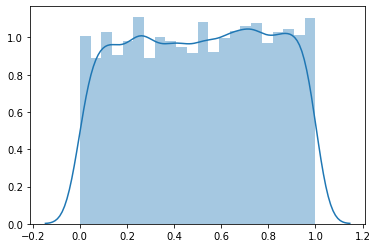

In [5]:
np.random.seed(1)
sns.distplot(ecdf_randn(np.random.randn(10000)))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

In [7]:
train = pd.read_csv("../data/train.csv", parse_dates=True, low_memory=False, index_col = "Date")
store = pd.read_csv("../data/store.csv", low_memory=False)

In [8]:
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

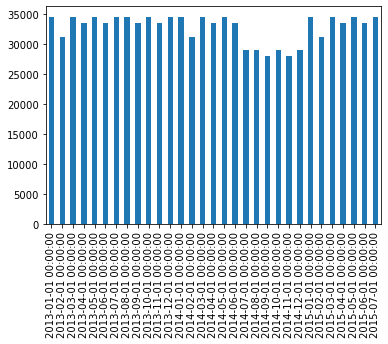

In [9]:
pd.to_datetime(pd.Series(train.index.to_list()).map(lambda date: "{}-{}".format(date.year, date.month))).value_counts().sort_index().plot.bar()

In [10]:
pd.set_option("max_columns", 100)

In [11]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [12]:
train["Store"].describe()

count    1.017209e+06
mean     5.584297e+02
std      3.219087e+02
min      1.000000e+00
25%      2.800000e+02
50%      5.580000e+02
75%      8.380000e+02
max      1.115000e+03
Name: Store, dtype: float64

In [13]:
train["Year"] = train.index.year
train["Month"] = train.index.month
train["Day"] = train.index.day
train["WeekOfYear"] = train.index.weekofyear

In [14]:
train["SalesPerCustomer"] = train["Sales"] / train["Customers"]

In [15]:
train["SalesPerCustomer"].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

In [16]:
pd.isna(train["SalesPerCustomer"]).sum() / train.shape[0]

0.16994442636665621

In [17]:
def plot_ecdf(series):
    cdf = ECDF(series)
    plt.plot(cdf.x, cdf.y)
    plt.xlabel(series.name)

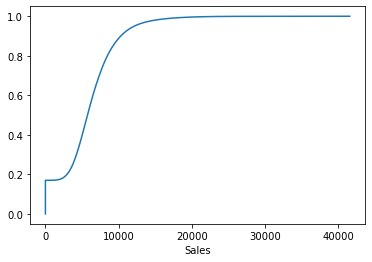

In [18]:
plot_ecdf(train["Sales"])

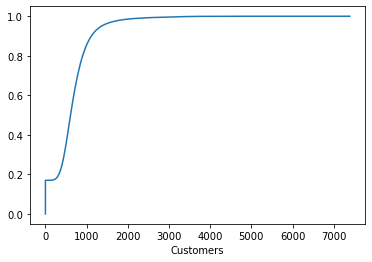

In [19]:
plot_ecdf(train["Customers"])

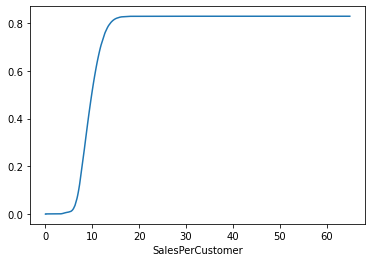

In [20]:
plot_ecdf(train["SalesPerCustomer"])

In [21]:
train[(train["Open"] == 0) & (train["Sales"] != 0)].shape[0]

0

In [22]:
train[(train["Open"] != 0) & (train["Sales"] == 0)].shape[0]

54

In [23]:
train = train[(train["Open"] != 0) & (train["Sales"] != 0)].copy()

In [24]:
store.shape

(1115, 10)

In [25]:
train[["Store"]].drop_duplicates().shape

(1115, 1)

In [26]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [27]:
store[["CompetitionDistance" ,"StoreType", "Assortment"]].groupby(["StoreType", "Assortment"]).count()

CompetitionDistance
StoreType Assortment                     
a         a                           381
          c                           220
b         a                             7
          b                             9
          c                             1
c         a                            77
          c                            71
d         a                           126
          c                           220

In [28]:
table = pd.pivot_table(data = store, values = "CompetitionDistance",
              index = "StoreType", columns = "Assortment", aggfunc = np.mean)
table.T

StoreType,a,b,c,d
Assortment,,,,
a,4058.661417,888.571429,2710.519481,6661.269841
b,NaN,1177.777778,NaN,NaN
c,6966.409091,1210.000000,4403.239437,7057.272727


In [29]:
table.columns.tolist(), table.index.tolist()

(['a', 'b', 'c'], ['a', 'b', 'c', 'd'])

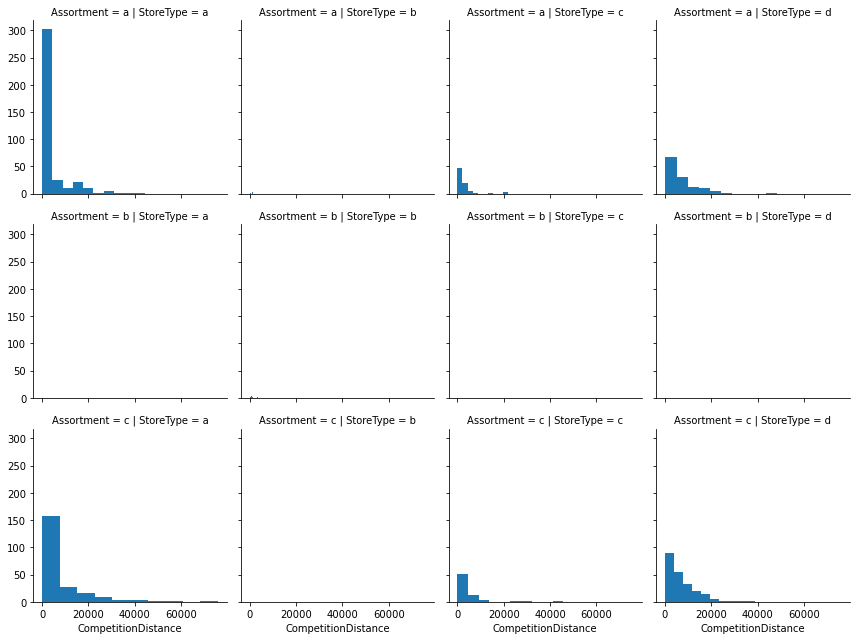

In [30]:
g = sns.FacetGrid(store, col = "StoreType", row = "Assortment",
             col_order = table.index.tolist(), row_order = table.columns.tolist())
g.map(plt.hist, "CompetitionDistance")

In [31]:
store.fillna(0, inplace = True)

In [32]:
pd.merge(train, store, how = "inner", on = "Store").shape

(844338, 22)

In [33]:
train_store = pd.merge(train, store, how = "inner", on = "Store")

In [34]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [35]:
cm = sns.light_palette("green", as_cmap=True)
train_store.groupby("StoreType")["Sales"].describe().style.background_gradient(cmap=cm)

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.000000,6925.697986,3277.351589,46.000000,4695.250000,6285.000000,8406.000000,41551.000000
b,15560.000000,10233.380141,5155.729868,1252.000000,6345.750000,9130.000000,13184.250000,38722.000000
c,112968.000000,6933.126425,2896.958579,133.000000,4916.000000,6408.000000,8349.250000,31448.000000
d,258768.000000,6822.300064,2556.401455,538.000000,5050.000000,6395.000000,8123.250000,38037.000000


In [36]:
cm = sns.light_palette("green", as_cmap=True)
train_store.groupby("StoreType")["Customers" ,"Sales"].sum().style.background_gradient(cmap=cm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [37]:
#train.head()
store_promo2_list_collect = train_store.groupby(["Store" ,"Promo2"])["Promo"].apply(list)

In [38]:
train_store_expand_date = pd.merge(train.reset_index(), store, how = "inner", on = "Store")

In [39]:
store_promo2_dict_collect = train_store_expand_date.groupby(["Store" ,"Promo2"])[["Promo", "Date"]].apply(dict)

In [40]:
def plot_single_record_in_dict_collect(input_dict, window = "30d"):
    date = input_dict["Date"].tolist()
    Promo = input_dict["Promo"].tolist()
    series = pd.Series(Promo)
    series.index = date
    series.resample(window).sum().plot()

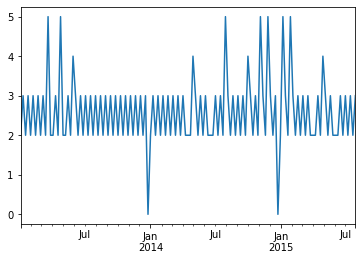

In [41]:
plot_single_record_in_dict_collect(store_promo2_dict_collect.iloc[0], window = "7D")

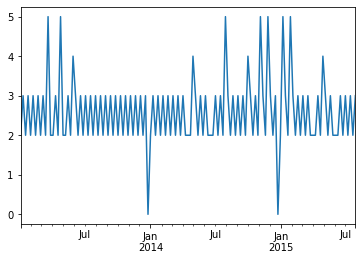

In [42]:
plot_single_record_in_dict_collect(store_promo2_dict_collect.iloc[2], window = "7D")

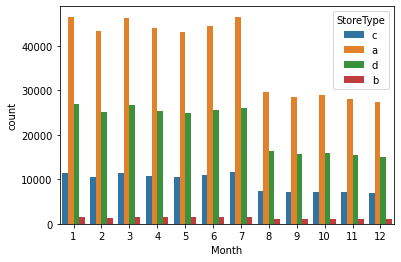

In [43]:
sns.countplot(data = train_store, x = "Month", hue = "StoreType")

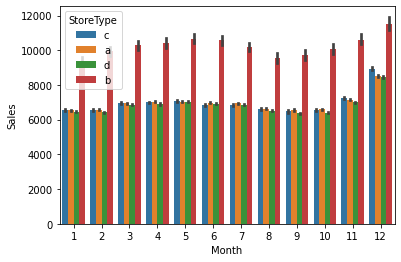

In [44]:
sns.barplot(data = train_store, x = "Month", y = "Sales", hue = "StoreType")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



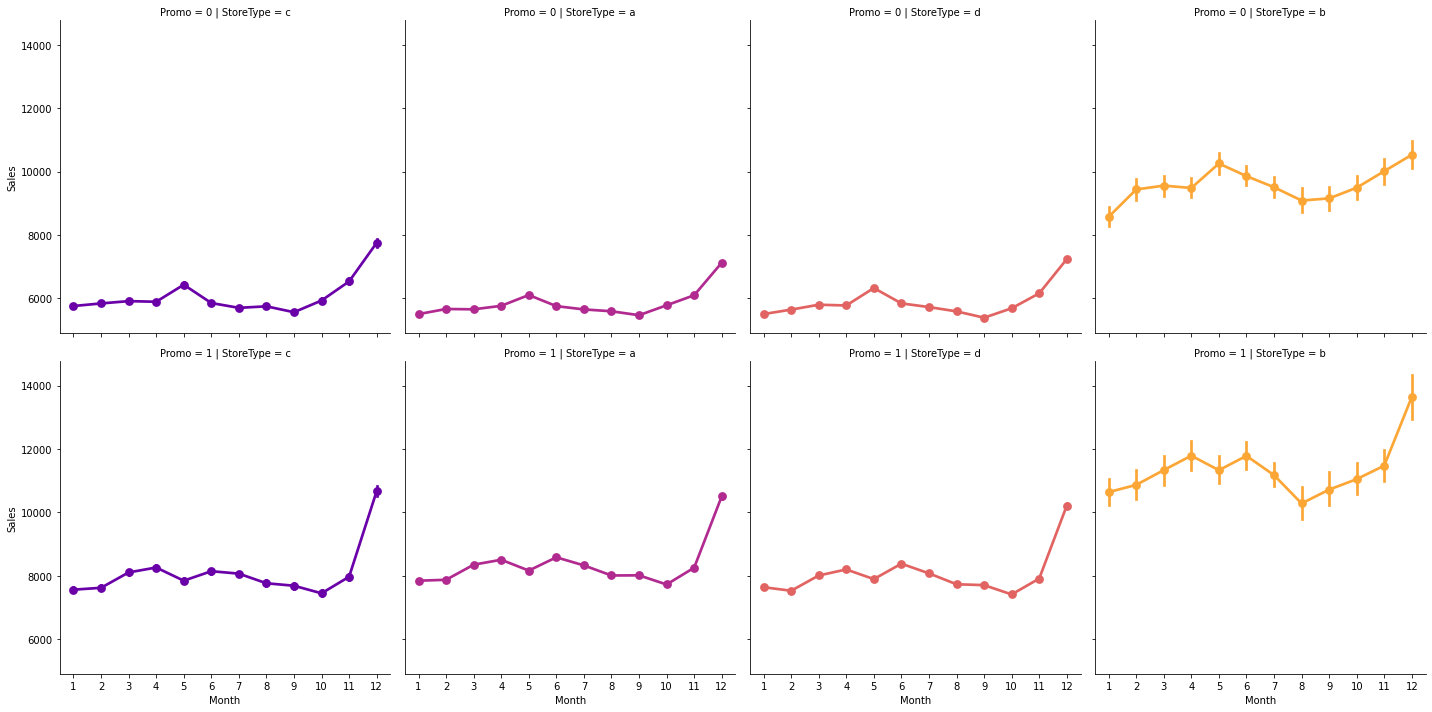

In [45]:
sns.factorplot(
    data = train_store, x = "Month", y = "Sales", col = "StoreType", palette = "plasma", hue = "StoreType", row = "Promo", kind = "point"
)   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



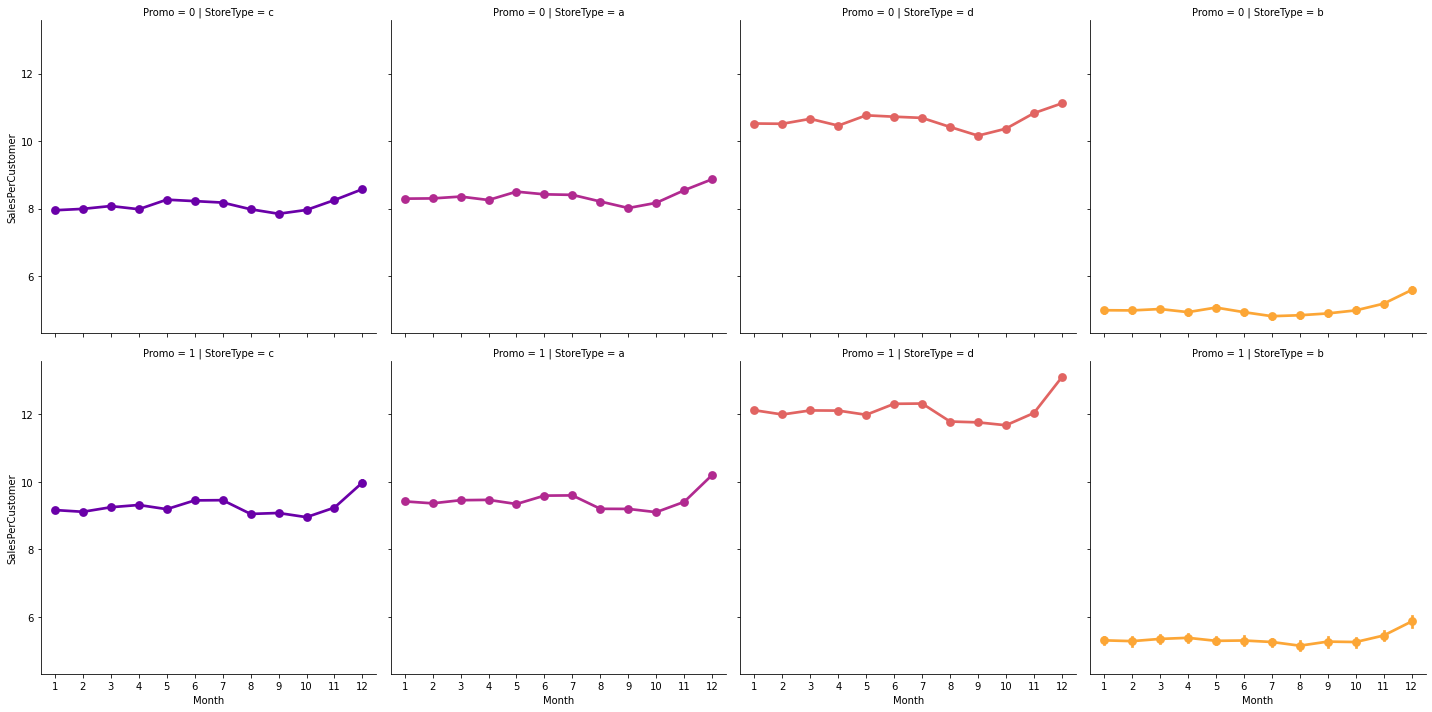

In [46]:
sns.factorplot(
    data = train_store, x = "Month", y = "SalesPerCustomer", col = "StoreType", palette = "plasma", hue = "StoreType", row = "Promo",
)   

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



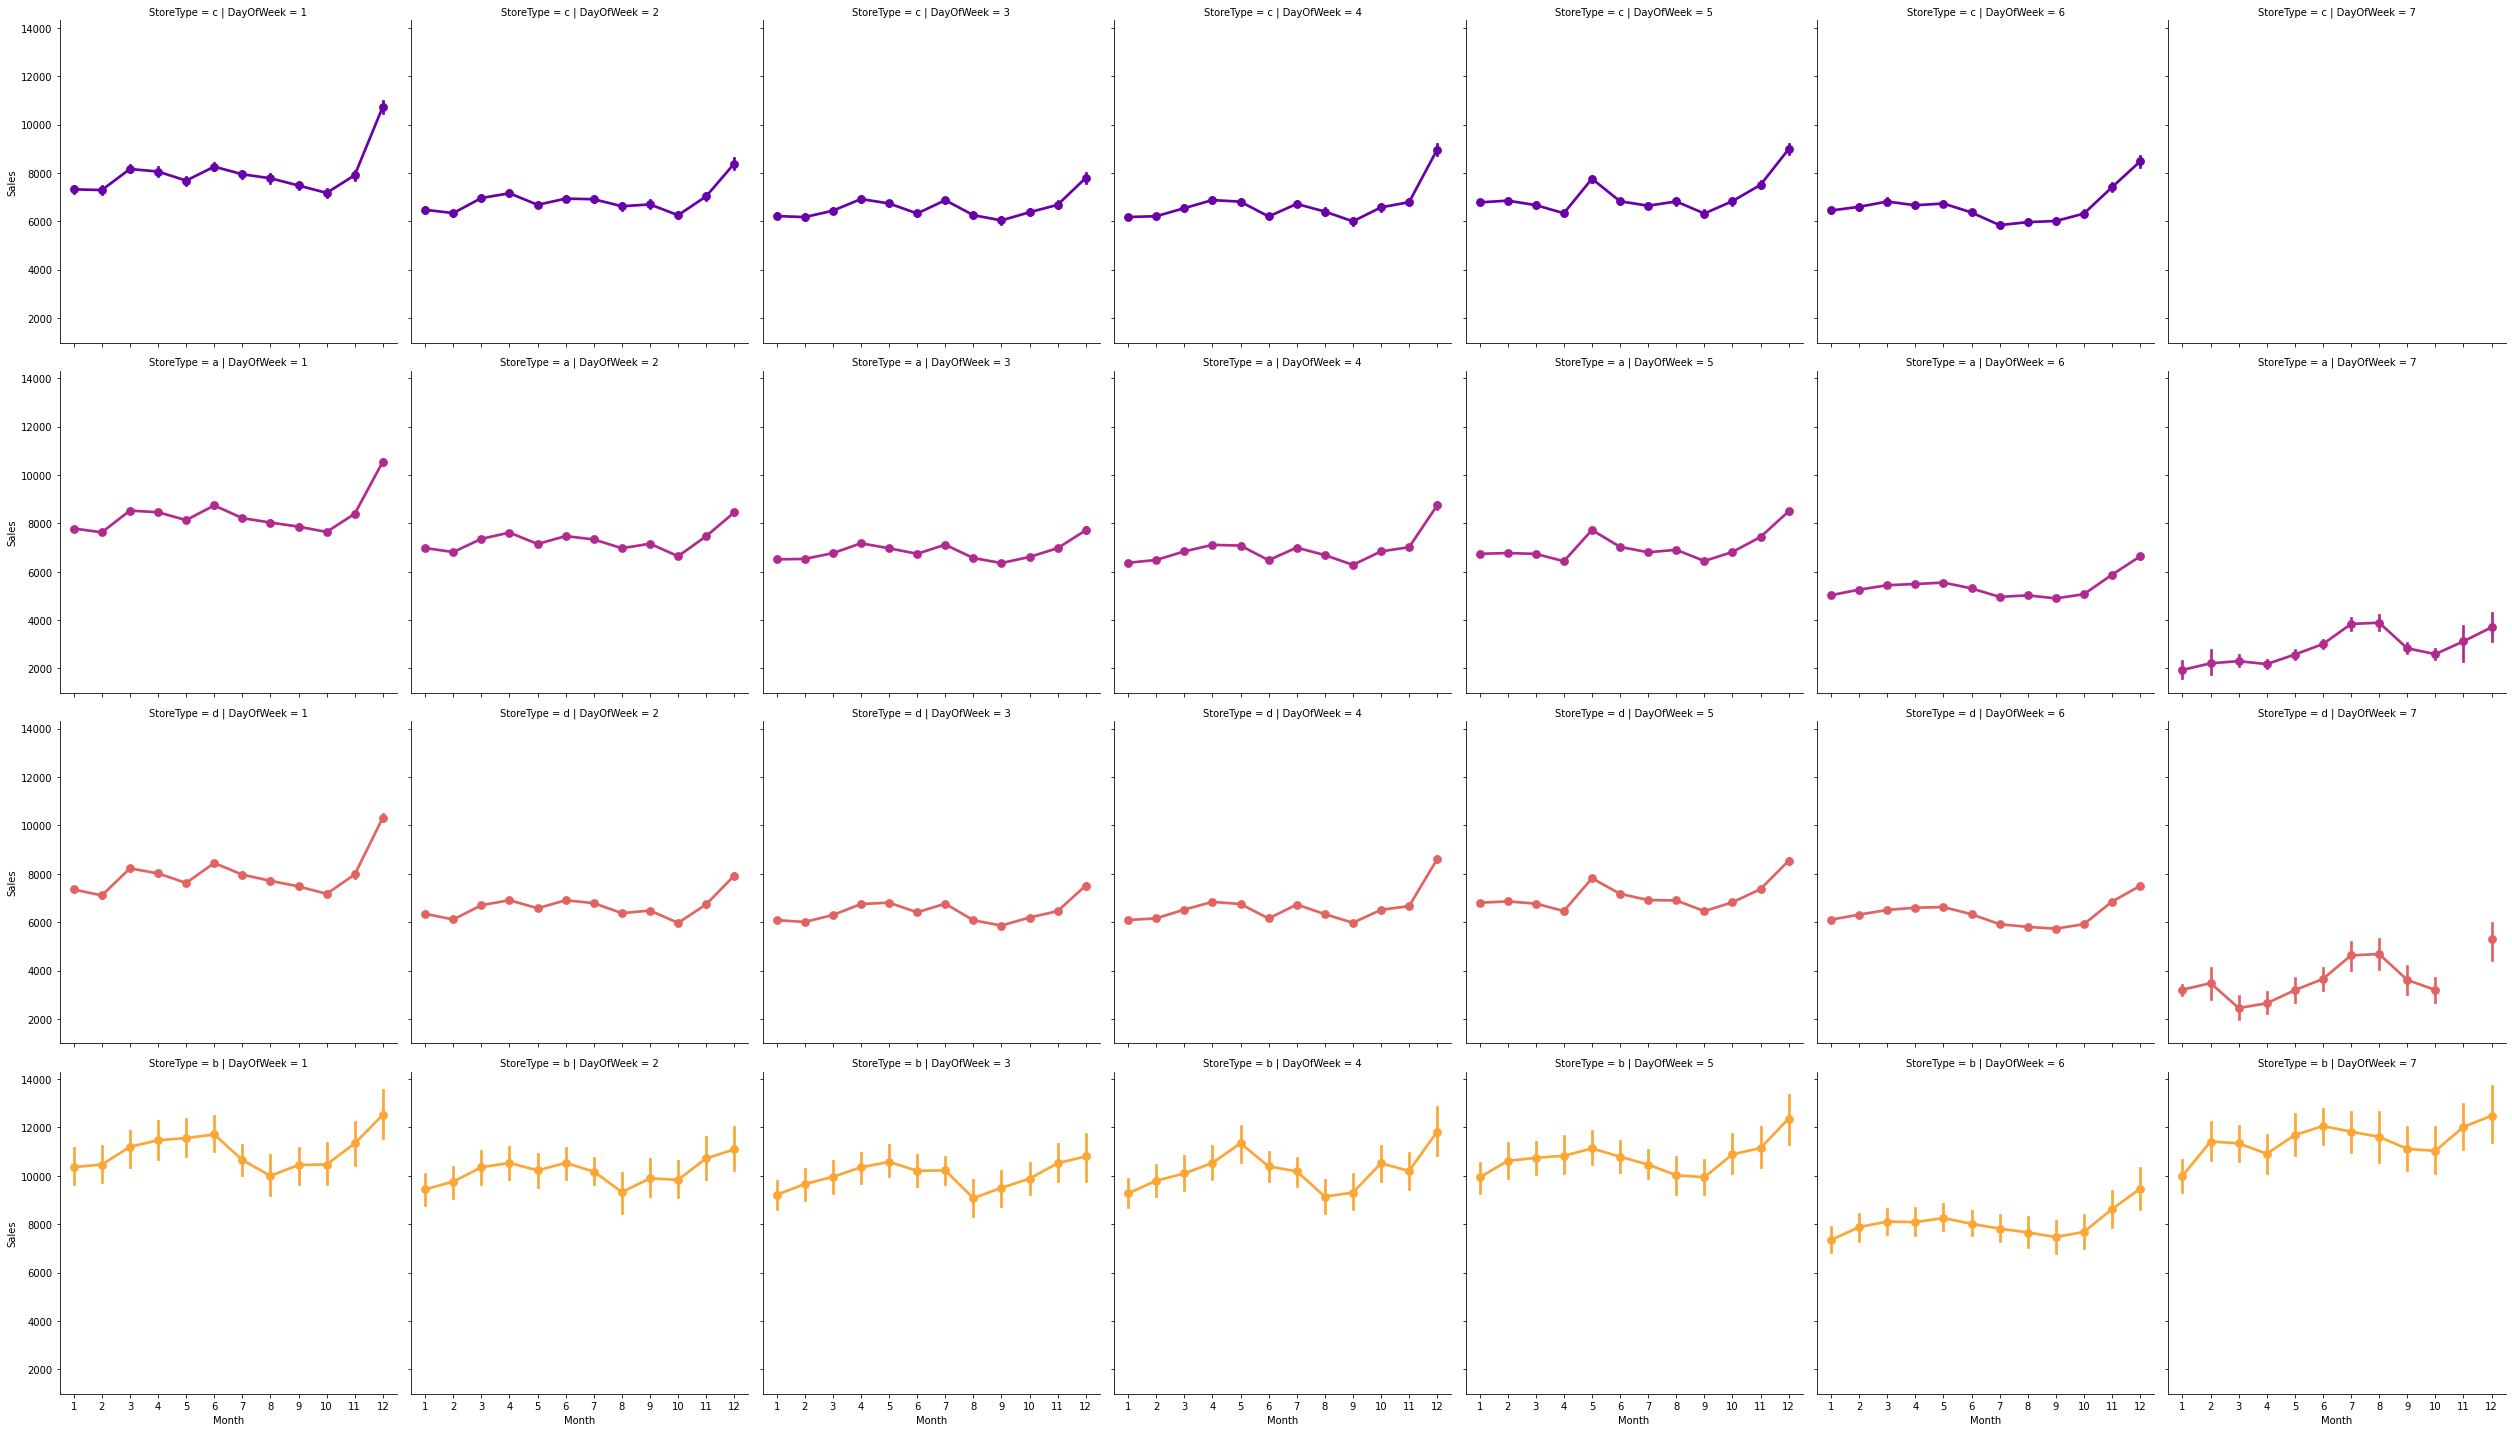

In [47]:
sns.factorplot(
    data = train_store, x = "Month", y = "Sales", col = "DayOfWeek", palette = "plasma", hue = "StoreType", row = "StoreType"
)

In [48]:
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

In [49]:
cm = sns.light_palette("green", as_cmap=True)
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean().style.background_gradient(cmap=cm)

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


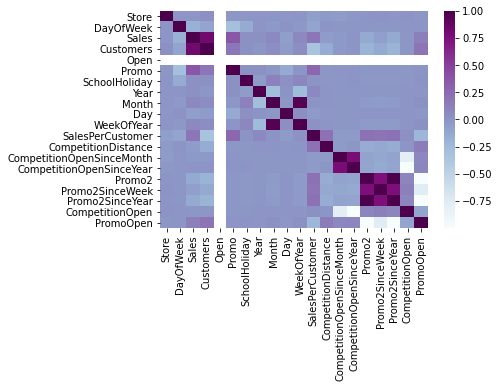

In [62]:
sns.heatmap(train_store.corr(), cmap = "BuPu")

In [63]:
corr_m = train_store.corr().copy()

In [64]:
from sklearn.cluster import SpectralBiclustering

In [65]:
model = SpectralBiclustering(n_clusters=3, random_state=0)
model.fit(corr_m.fillna(0.0).values)

SpectralBiclustering(init='k-means++', method='bistochastic', mini_batch=False,
                     n_best=3, n_clusters=3, n_components=6, n_init=10,
                     n_jobs=None, n_svd_vecs=None, random_state=0,
                     svd_method='randomized')

In [66]:
fit_data = corr_m.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

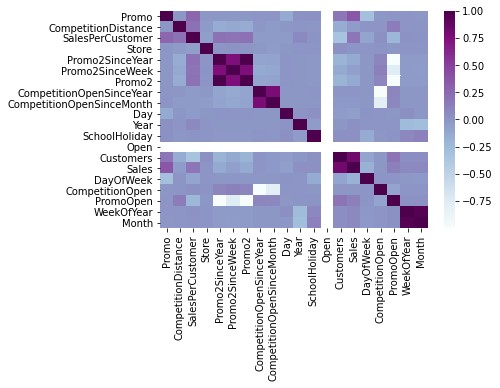

In [67]:
sns.heatmap(fit_data, cmap = "BuPu")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



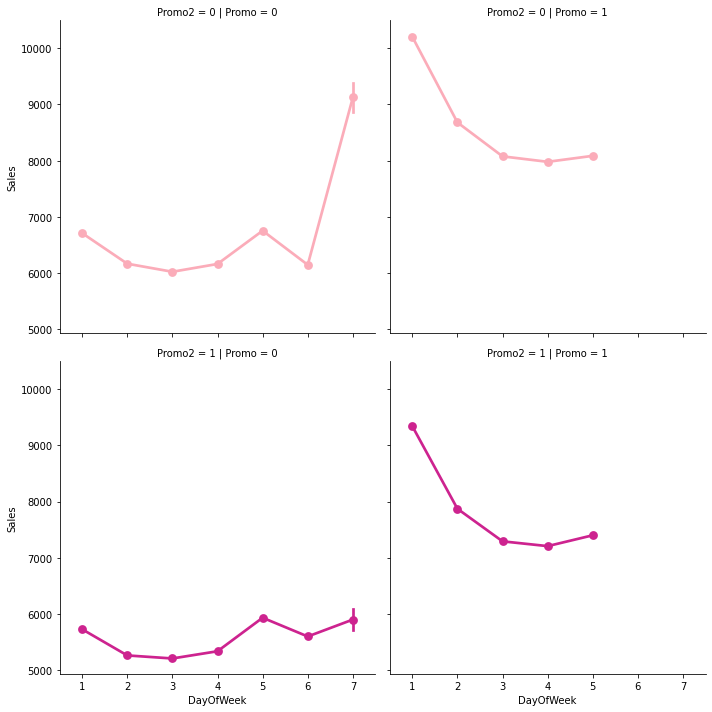

In [68]:
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

In [69]:
storetype_sales_dict_collect = train_store_expand_date.groupby(["StoreType", "Store"])[["Sales", "Date"]].apply(dict)

In [70]:
storetype_sales_dict_collect.head()

StoreType  Store
a          2        {'Sales': [6064, 5567, 6402, 5671, 6627, 2512,...
           3        {'Sales': [8314, 8977, 7610, 8864, 8107, 3878,...
           5        {'Sales': [4822, 4943, 5899, 6083, 7059, 2030,...
           6        {'Sales': [5651, 4790, 5275, 4839, 5723, 2892,...
           7        {'Sales': [15344, 11560, 12074, 12342, 14869, ...
dtype: object

In [71]:
storetype_sales_dict_collect_flatten = storetype_sales_dict_collect.reset_index()

In [72]:
from functools import reduce
def generate_range(store_type = "a", col = "Date"):
    assert store_type in ["a", "b", "c", "d"]
    assert col in ["Date", "Sales"]
    if col == "Date":
        date_df =pd.DataFrame(list(zip(*storetype_sales_dict_collect_flatten[storetype_sales_dict_collect_flatten["StoreType"] == store_type][0].map(lambda dict_: (dict_[col].min(), dict_[col].max())).values.tolist())))
        return (date_df.iloc[0].min(), date_df.iloc[1].max())
    else:
        date_start, date_end =  generate_range(store_type, col = "Date")
        date_range = pd.date_range(date_start, date_end)
        date_df = pd.DataFrame(date_range.values.reshape([-1, 1]))
        date_df.columns = ["RootDate"]
        def process_single_dict(input_dict):
            date = input_dict["Date"].tolist()
            sales = input_dict["Sales"].tolist()
            df = pd.concat(list(map(pd.Series ,[date, sales])), axis = 1)
            df.columns = ["Date", "Sales"]
            return df
        lookup_df = reduce(lambda a, b: pd.merge(a, b, left_on = "RootDate", right_on="Date", how = "outer") ,[date_df] +list(map(process_single_dict,storetype_sales_dict_collect_flatten[storetype_sales_dict_collect_flatten["StoreType"] == store_type][0].values.tolist())))
        store_id_series = storetype_sales_dict_collect_flatten[storetype_sales_dict_collect_flatten["StoreType"] == store_type]["Store"]
        return lookup_df, store_id_series

In [73]:
generate_range()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [74]:
a_sales_tuple = generate_range("a", "Sales")

In [85]:
a_sales_tuple[0].shape

(942, 1205)

In [86]:
a_sales_tuple[0].shape, a_sales_tuple[1].dropna().shape

((942, 1205), (602,))

In [87]:
pd.Series(a_sales_tuple[0].columns.tolist())

0       RootDate
1         Date_x
2        Sales_x
3         Date_y
4        Sales_y
          ...   
1200     Sales_y
1201      Date_x
1202     Sales_x
1203      Date_y
1204     Sales_y
Length: 1205, dtype: object

In [88]:
def process_merge_df_and_store_ids(merge_df, store_ids):
    if "Sales" in merge_df.columns.tolist():
        req_df = merge_df[["Sales_x", "Sales_y", "Sales"]].copy()
    else:
        req_df = merge_df[["Sales_x", "Sales_y"]].copy()
    req_df.index = merge_df["RootDate"]
    req_df.columns = store_ids.values.tolist()
    return req_df.sort_index().fillna(0.0)

In [89]:
a_series_df = process_merge_df_and_store_ids(*a_sales_tuple)

In [90]:
a_series_df.head()

,2,3,5,6,7,8,9,10,11,12,14,16,17,19,22,24,27,28,30,32,33,36,39,40,42,44,47,48,51,53,55,58,59,61,62,65,67,68,71,72,73,74,78,79,81,82,83,84,86,87,...,1027,1028,1029,1030,1033,1034,1035,1037,1039,1040,1042,1045,1047,1049,1052,1053,1054,1058,1060,1063,1064,1065,1066,1069,1071,1072,1073,1075,1076,1077,1079,1080,1084,1086,1088,1090,1091,1092,1095,1096,1098,1099,1100,1102,1106,1107,1108,1111,1113,1114
RootDate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,4422.0,4253.0,8244.0,4903.0,8913.0,5253.0,5593.0,3514.0,8674.0,5683.0,8910.0,4144.0,7959.0,6538.0,5152.0,4516.0,5177.0,6484.0,8096.0,7041.0,3692.0,3075.0,7181.0,4102.0,4230.0,5289.0,8256.0,7770.0,6676.0,2326.0,6996.0,5298.0,7067.0,5668.0,6719.0,4229.0,9196.0,4553.0,9651.0,5170.0,5198.0,8759.0,5421.0,6092.0,6950.0,4981.0,5882.0,7029.0,8369.0,8156.0,...,5340.0,6913.0,4179.0,3908.0,5145.0,5272.0,4072.0,7316.0,8837.0,4662.0,1949.0,2947.0,7251.0,3021.0,6983.0,10937.0,4048.0,5485.0,4041.0,7916.0,4344.0,7049.0,12407.0,8903.0,6676.0,3529.0,3232.0,6026.0,6357.0,8032.0,8282.0,3633.0,7750.0,5742.0,3500.0,5012.0,5685.0,6443.0,12956.0,4704.0,12755.0,9308.0,5642.0,11054.0,4330.0,11883.0,6676.0,3955.0,5097.0,20642.0
2013-01-03,4159.0,3465.0,7231.0,4602.0,7375.0,4169.0,5102.0,3894.0,7893.0,6219.0,7987.0,3527.0,6925.0,6199.0,4585.0,4031.0,4722.0,5303.0,6644.0,7246.0,3890.0,2994.0,4874.0,3060.0,3371.0,5576.0,6727.0,6522.0,5714.0,1811.0,5897.0,4829.0,7162.0,4953.0,4634.0,3838.0,7861.0,4541.0,7526.0,5181.0,4079.0,7164.0,4509.0,6731.0,5661.0,4346.0,5190.0,5955.0,6937.0,6934.0,...,5269.0,6404.0,3749.0,3468.0,5213.0,5181.0,4059.0,6785.0,8144.0,3950.0,1625.0,3291.0,7705.0,2673.0,5373.0,9379.0,4067.0,4881.0,3814.0,7226.0,3620.0,6377.0,10287.0,8240.0,6474.0,3046.0,3342.0,6112.0,5801.0,6563.0,7582.0,3030.0,7333.0,4938.0,3051.0,4408.0,5142.0,5892.0,11298.0,3675.0,8089.0,9210.0,4607.0,9121.0,3387.0,8988.0,5323.0,3151.0,4579.0,18463.0
2013-01-04,4484.0,4456.0,7758.0,4798.0,7768.0,4734.0,5853.0,4053.0,8361.0,5035.0,8462.0,3604.0,8273.0,5580.0,6323.0,4622.0,5322.0,5462.0,6859.0,7737.0,3932.0,3043.0,5943.0,3264.0,3487.0,5106.0,6861.0,6723.0,6174.0,2005.0,6267.0,4201.0,7184.0,5047.0,5248.0,4525.0,8196.0,4695.0,8224.0,5678.0,4285.0,6949.0,4364.0,6107.0,5977.0,5358.0,5309.0,6428.0,6992.0,6651.0,...,6608.0,6525.0,3177.0,3626.0,4709.0,4916.0,3424.0,6634.0,8018.0,4088.0,1458.0,2781.0,8416.0,2941.0,6508.0,9606.0,4384.0,5150.0,3595.0,7966.0,4109.0,5981.0,12446.0,6836.0,6643.0,3859.0,3343.0,5802.0,6615.0,6725.0,6351.0,3816.0,7671.0,5467.0,3621.0,3648.0,5414.0,6753.0,10233.0,4307.0,8404.0,8489.0,5241.0,9903.0,3995.0,7870.0,5979.0,3990.0,4640.0,18371.0
2013-01-05,2342.0,1590.0,5218.0,4254.0,5734.0,2519.0,2576.0,2645.0,7969.0,5643.0,8293.0,2435.0,7587.0,5673.0,6605.0,3583.0,2384.0,3332.0,5456.0,7263.0,2373.0,2521.0,6311.0,2649.0,3289.0,1870.0,7299.0,4644.0,7024.0,1465.0,6533.0,2396.0,7205.0,4694.0,5141.0,2348.0,7020.0,3636.0,5054.0,3417.0,3011.0,6201.0,3130.0,3342.0,6172.0,3438.0,5684.0,4273.0,5426.0,7361.0,...,4962.0,7403.0,2860.0,2501.0,3274.0,2207.0,2337.0,4599.0,7825.0,3317.0,1076.0,1296.0,6065.0,2835.0,5694.0,9114.0,2647.0,3475.0,2920.0,5391.0,4385.0,7963.0,4746.0,9478.0,6029.0,2388.0,1128.0,2455.0,6234.0,6398.0,4854.0,3155.0,6056.0,4012.0,3421.0,1864.0,2874.0,3932.0,13819.0,2671.0,7522.0,6024.0,2267.0,10876.0,3456.0,8773.0,5541.0,5128.0,3325.0,18856.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

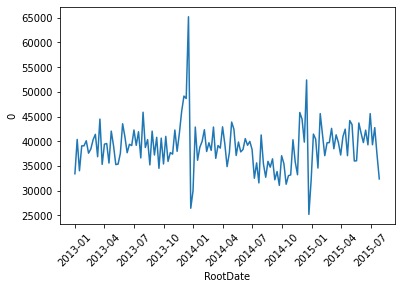

In [91]:
ax = sns.lineplot(data = a_series_df.apply(np.mean, axis = 1).resample("7D").sum().reset_index(),
            x = "RootDate", y = 0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

In [92]:
def single_series_resample(series, index, window = "7D"):
    series = pd.Series(series.values.tolist())
    series.index = index.tolist()
    return series.resample(window).sum()

In [93]:
from functools import partial
a_series_index = a_series_df.index
mean_head_a_series = np.asarray(a_series_df.apply(np.mean, axis = 1).resample("7D").sum().values.reshape([1, -1]).tolist()+a_series_df.apply(partial(single_series_resample, index = a_series_index), axis = 0).T.values.tolist())

In [95]:
!pip3 install dtaidistance

     |████████████████████████████████| 327kB 2.8MB/s eta 0:00:01
  Created wheel for dtaidistance: filename=dtaidistance-1.2.3-cp36-cp36m-linux_x86_64.whl size=624162 sha256=baccaeeca21f5f7b2a8485f7c636f11b088e2495639015f7608a05d826c0a7da
  Stored in directory: /root/.cache/pip/wheels/9f/9a/74/42c5b9dc714bb5a70b426df08cc860e6a741bc199004873e1b
Successfully built dtaidistance


In [96]:
from dtaidistance import dtw
ds_a = dtw.distance_matrix_fast(mean_head_a_series)

In [97]:
ds_a.shape

(603, 603)

In [98]:
ds_a

array([[             inf,   72448.22764598,   88591.72224624, ...,
         134833.68588331,   60464.94430887,  918866.94583413],
       [             inf,              inf,   23882.37754077, ...,
         112847.43971841,   28102.94566411, 1067429.11827203],
       [             inf,              inf,              inf, ...,
         111530.24911655,   31659.9051799 , 1088290.66094725],
       ...,
       [             inf,              inf,              inf, ...,
                     inf,  103242.75495162, 1068174.1428667 ],
       [             inf,              inf,              inf, ...,
                     inf,              inf, 1051966.99478976],
       [             inf,              inf,              inf, ...,
                     inf,              inf,              inf]])

In [99]:
min_ds_idx, max_ds_idx = np.argmin(ds_a[0, 1:])  + 1,np.argmax(ds_a[0, 1:]) + 1

In [100]:
min_ds_series = pd.Series(mean_head_a_series[min_ds_idx, :])
min_ds_series.index = a_series_df.apply(np.mean, axis = 1).resample("7D").sum().index

max_ds_series = pd.Series(mean_head_a_series[max_ds_idx, :])
max_ds_series.index = a_series_df.apply(np.mean, axis = 1).resample("7D").sum().index


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

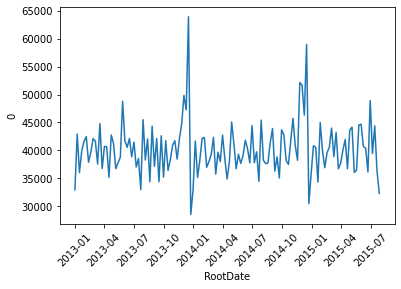

In [101]:
ax = sns.lineplot(data = min_ds_series.reset_index(), x = "RootDate", y = 0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

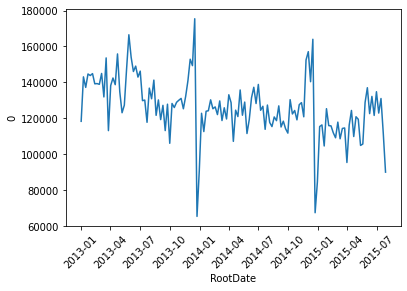

In [102]:
ax = sns.lineplot(data = max_ds_series.reset_index(), x = "RootDate", y = 0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

In [103]:
a_series_df.columns.tolist()[min_ds_idx]

176

In [104]:
def seek_representaion_series(salestype = "a"):
    assert salestype in ["a", "b", "c", "d"]
    sales_tuple = generate_range(salestype, "Sales")
    series_df = process_merge_df_and_store_ids(*sales_tuple)
    series_index = series_df.index
    mean_head_series = np.asarray(series_df.apply(np.mean, axis = 1).resample("7d").sum().values.reshape([1, -1]).tolist()+series_df.apply(partial(single_series_resample, index = series_index), axis = 0).T.values.tolist())
    ds = dtw.distance_matrix_fast(mean_head_series)
    min_ds_idx, max_ds_idx = np.argmin(ds[0, 1:])  + 1,np.argmax(ds[0, 1:]) + 1
    min_ds_series = pd.Series(mean_head_series[min_ds_idx, :])
    min_ds_series.index = series_df.apply(np.mean, axis = 1).resample("7d").sum().index
    ax = sns.lineplot(data = min_ds_series.reset_index(), x = "RootDate", y = 0)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    #return series_df.columns.tolist()[min_ds_idx]
    return min_ds_series

In [ ]:
sales_a_7D = seek_representaion_series("a")

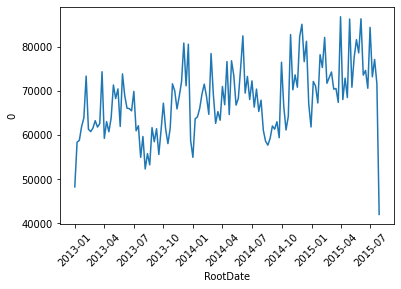

In [107]:
sales_b_7D = seek_representaion_series("b")

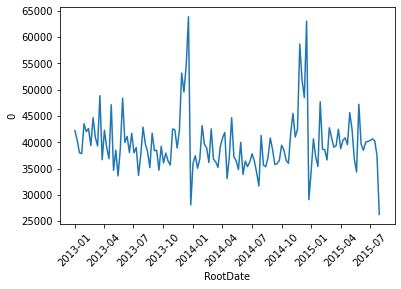

In [108]:
sales_c_7D = seek_representaion_series("c")

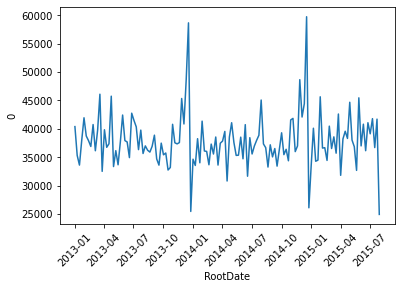

In [109]:
sales_d_7D = seek_representaion_series("d")

In [110]:
len(pd.Series(train_store[train_store["Store"] == 13].index.tolist()).value_counts())

621

In [111]:
train_store[train_store["StoreType"] == "d"]["Store"].value_counts().index

Int64Index([ 578,  299,  867,   54,  180,  741,   75,  230,  585,   31,
            ...
             430,  277, 1067,  288,  342,  215,   13,   20,  638,  100],
           dtype='int64', length=348)

In [112]:
len(pd.Series(train_store[train_store["Store"] == 578].index.tolist()).value_counts())

901

In [113]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F

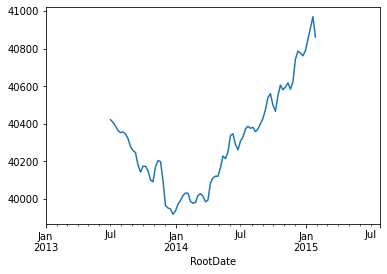

In [114]:
decomposition_a = seasonal_decompose(sales_a_7D, model = 'additive', freq = int(365 / 7))
decomposition_a.trend.plot()

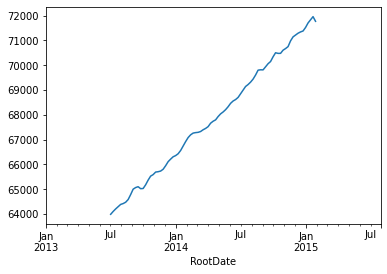

In [115]:
decomposition_b = seasonal_decompose(sales_b_7D, model = 'additive', freq = int(365 / 7))
decomposition_b.trend.plot()

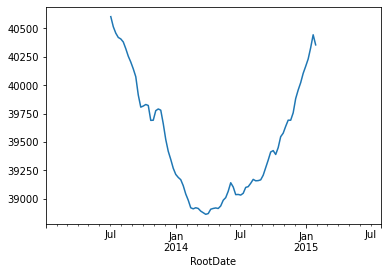

In [116]:
decomposition_c = seasonal_decompose(sales_c_7D, model = 'additive', freq = int(365 / 7))
decomposition_c.trend.plot()

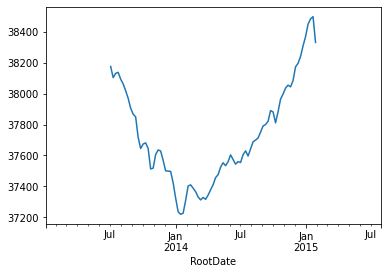

In [117]:
decomposition_d = seasonal_decompose(sales_d_7D, model = 'additive', freq = int(365 / 7))
decomposition_d.trend.plot()

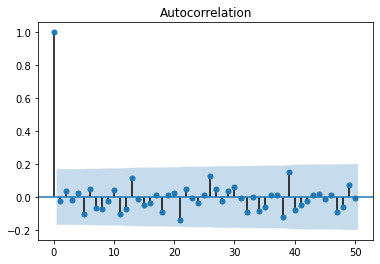

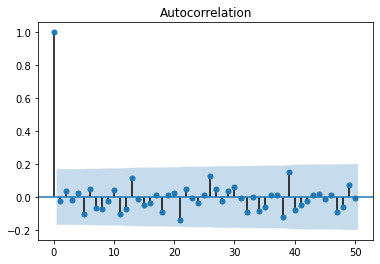

In [118]:
plot_acf(sales_a_7D, lags = 50)

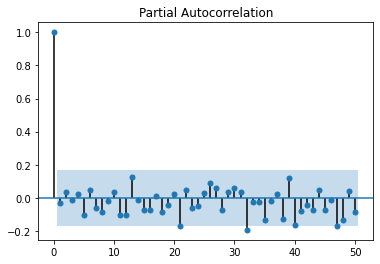

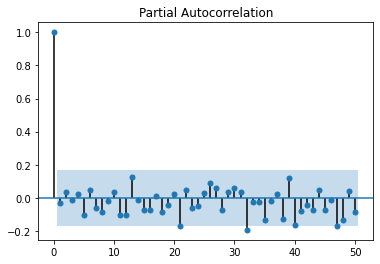

In [119]:
plot_pacf(sales_a_7D, lags = 50)

In [120]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,82.0,24187.75


In [121]:
train_store_expand_date.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2015-07-30,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2015-07-29,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2015-07-28,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,2015-07-27,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [122]:
train_store.shape, train_store_expand_date.shape

((844338, 24), (844338, 23))

In [123]:
df = train_store_expand_date[train_store_expand_date["Store"] == 1]

In [124]:
simple_df = df[["Date", "Sales"]].copy()

In [125]:
simple_df.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [126]:
sales = simple_df.copy().rename(columns = {
    "Date": "ds", "Sales": "y"
})

In [127]:
sales.head()

,ds,y
0,2015-07-31,5263
1,2015-07-30,5020
2,2015-07-29,4782
3,2015-07-28,5011
4,2015-07-27,6102


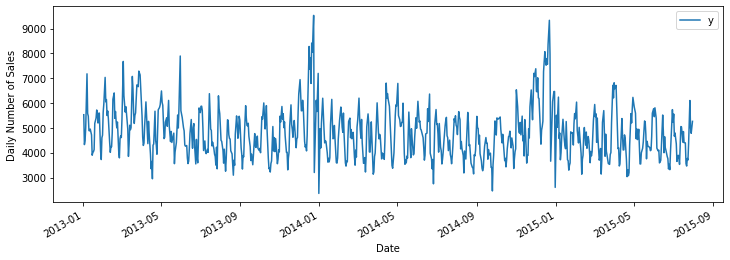

In [128]:
ax = sales.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [129]:
df["StateHoliday"].value_counts().sort_index()

0    781
Name: StateHoliday, dtype: int64

In [130]:
train_store_expand_date["StateHoliday"].value_counts().sort_index()

0    843428
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [131]:
holiday_df = train_store_expand_date[train_store_expand_date["StateHoliday"] != "0"][["Date", "StateHoliday"]].copy()

In [132]:
holiday_df["timezone"] = holiday_df["Date"].astype(int).map(lambda x: x / int(1e9)).astype(int)

In [133]:
help(sns.violinplot)

Help on function violinplot in module seaborn.categorical:

violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, ax=None, **kwargs)
    Draw a combination of boxplot and kernel density estimate.
    
    A violin plot plays a similar role as a box and whisker plot. It shows the
    distribution of quantitative data across several levels of one (or more)
    categorical variables such that those distributions can be compared. Unlike
    a box plot, in which all of the plot components correspond to actual
    datapoints, the violin plot features a kernel density estimation of the
    underlying distribution.
    
    This can be an effective and attractive way to show multiple distributions
    of data at once, but keep in mind that the estimation procedure is
    influenced by the sa

In [134]:
holiday_df["Date"].sort_values().drop_duplicates()

510780   2013-01-01
715977   2013-01-06
553720   2013-03-29
655518   2013-04-01
829156   2013-05-01
156594   2013-05-09
715858   2013-05-20
738656   2013-05-30
836526   2013-08-15
398335   2013-10-03
362067   2013-10-31
386946   2013-11-01
515099   2013-12-25
510445   2013-12-26
553442   2014-01-01
265749   2014-01-06
373242   2014-04-18
553332   2014-04-21
424696   2014-05-01
194556   2014-05-29
514933   2014-06-09
751421   2014-06-19
586605   2014-10-03
151516   2014-10-31
828607   2014-11-01
372991   2014-12-25
715273   2014-12-26
194339   2015-01-01
265384   2015-01-06
194247   2015-04-03
196738   2015-04-06
715147   2015-05-01
232184   2015-05-14
654783   2015-05-25
329971   2015-06-04
Name: Date, dtype: datetime64[ns]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



([<matplotlib.axis.YTick at 0x7fd9006b9f28>,
 [Text(0, 0, '2012-10-12'),
  Text(0, 0, '2013-02-04'),
  Text(0, 0, '2013-05-31'),
  Text(0, 0, '2013-09-24'),
  Text(0, 0, '2014-01-17'),
  Text(0, 0, '2014-05-13'),
  Text(0, 0, '2014-09-06'),
  Text(0, 0, '2014-12-31'),
  Text(0, 0, '2015-04-25'),
  Text(0, 0, '2015-08-19')])

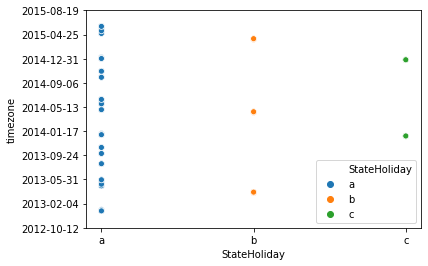

In [135]:
ax = sns.scatterplot(data = holiday_df, x = "StateHoliday", y = "timezone", hue = "StateHoliday")
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ticks, labels = plt.yticks()
req_labels = pd.Series(ticks).map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')).values.tolist()
def set_text(tx_obj, text):
    tx_obj.set_text(text)
    return tx_obj
labels_trans = list(map(lambda idx: set_text(labels[idx] ,req_labels[idx]),range(len(labels))))
plt.yticks(ticks, req_labels)

In [136]:
holiday_df["Month"] = holiday_df["Date"].dt.month
holiday_df["Day"] = holiday_df["Date"].dt.day

In [137]:
holiday_df.head()

,Date,StateHoliday,timezone,Month,Day
1030,2014-10-03,a,1412294400,10,3
1334,2013-10-03,a,1380758400,10,3
3177,2015-06-04,a,1433376000,6,4
3466,2014-06-19,a,1403136000,6,19
3784,2013-05-30,a,1369872000,5,30


In [138]:
holiday_reduce_year_df = holiday_df[["Month", "Day", "StateHoliday"]].copy().drop_duplicates()
holiday_reduce_year_df["Month_Day"] = holiday_reduce_year_df.apply(lambda row: "{}-{}".format("0{}".format(row["Month"]) if len(str(row["Month"])) == 1 else row["Month"], "0{}".format(row["Day"]) if len(str(row["Day"])) == 1 else row["Day"]), axis = 1)

In [139]:
holiday_reduce_year_df.sort_values(by = ["StateHoliday", "Month_Day"], ascending=True)

,Month,Day,StateHoliday,Month_Day
63656,1,1,a,01-01
265384,1,6,a,01-06
39976,5,1,a,05-01
64258,5,9,a,05-09
63523,5,14,a,05-14
64247,5,20,a,05-20
63512,5,25,a,05-25
63873,5,29,a,05-29
3784,5,30,a,05-30
3177,6,4,a,06-04


In [140]:
pd.to_datetime(holiday_reduce_year_df["Month_Day"].map(lambda x: "2000-{}".format(x)))

1030     2000-10-03
3177     2000-06-04
3466     2000-06-19
3784     2000-05-30
39976    2000-05-01
40126    2000-10-31
43450    2000-08-15
63512    2000-05-25
63523    2000-05-14
63561    2000-04-06
63564    2000-04-03
63656    2000-01-01
63662    2000-12-26
63663    2000-12-25
63862    2000-06-09
63873    2000-05-29
63911    2000-04-21
63914    2000-04-18
64247    2000-05-20
64258    2000-05-09
64296    2000-04-01
64299    2000-03-29
251846   2000-11-01
265384   2000-01-06
Name: Month_Day, dtype: datetime64[ns]

In [141]:
holiday_reduce_year_df["fake_timezone"] = pd.to_datetime(holiday_reduce_year_df["Month_Day"].map(lambda x: "2000-{}".format(x))).astype(int).map(lambda x: x / int(1e9)).astype(int)

In [142]:
holiday_reduce_year_df

,Month,Day,StateHoliday,Month_Day,fake_timezone
1030,10,3,a,10-03,970531200
3177,6,4,a,06-04,960076800
3466,6,19,a,06-19,961372800
3784,5,30,a,05-30,959644800
39976,5,1,a,05-01,957139200
40126,10,31,a,10-31,972950400
43450,8,15,a,08-15,966297600
63512,5,25,a,05-25,959212800
63523,5,14,a,05-14,958262400
63561,4,6,b,04-06,954979200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



([<matplotlib.axis.YTick at 0x7fd8fb0e3ef0>,
 [Text(0, 0, '02-08'),
  Text(0, 0, '04-06'),
  Text(0, 0, '06-03'),
  Text(0, 0, '07-30'),
  Text(0, 0, '09-26'),
  Text(0, 0, '11-23')])

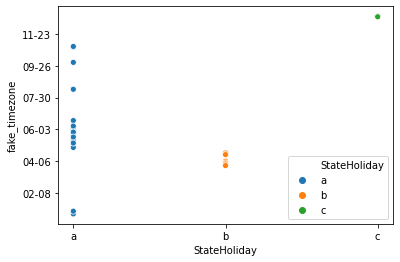

In [143]:
ax = sns.scatterplot(data = holiday_reduce_year_df, x = "StateHoliday", y = "fake_timezone", hue = "StateHoliday")
ticks, labels = plt.yticks()
req_labels = pd.Series(ticks).map(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d')).map(lambda x: x[(x.find("-") + 1) :]).values.tolist()
plt.yticks(ticks[1:-1], req_labels[1:-1])


In [144]:
train_store_expand_date[["SchoolHoliday", "Date"]].drop_duplicates().shape, train_store_expand_date[["SchoolHoliday", "Date"]].shape

((1383, 2), (844338, 2))

In [145]:
school_holiday_df = train_store_expand_date[["SchoolHoliday", "Date"]].drop_duplicates()

In [146]:
date_df = school_holiday_df[["Date"]].drop_duplicates()

In [147]:
school_holiday_df.shape, date_df.shape

((1383, 2), (942, 1))

In [148]:
school_holiday_df.groupby("Date")["SchoolHoliday"].apply(list).map(len).value_counts()

1    501
2    441
Name: SchoolHoliday, dtype: int64

In [149]:
school_holiday_df.groupby("Date")["SchoolHoliday"].apply(list)[school_holiday_df.groupby("Date")["SchoolHoliday"].apply(list).map(len) == 2]

Date
2013-01-03    [1, 0]
2013-01-04    [1, 0]
2013-01-05    [1, 0]
2013-01-06    [0, 1]
2013-01-07    [1, 0]
               ...  
2015-07-27    [1, 0]
2015-07-28    [1, 0]
2015-07-29    [1, 0]
2015-07-30    [1, 0]
2015-07-31    [1, 0]
Name: SchoolHoliday, Length: 441, dtype: object

In [150]:
schoolh_by_store = train_store_expand_date[["Store", "SchoolHoliday", "Date"]].groupby("Store")[["SchoolHoliday", "Date"]].apply(dict)

In [151]:
schoolh_by_store

Store
1       {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 0, 0, 0, ...
2       {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
3       {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
4       {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
5       {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
                              ...                        
1111    {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
1112    {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
1113    {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
1114    {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 1, 1, 1, ...
1115    {'SchoolHoliday': [1, 1, 1, 1, 1, 0, 0, 0, 0, ...
Length: 1115, dtype: object

In [152]:
from functools import reduce
inter_dates = sorted(list(reduce(lambda a, b: a.intersection(b) ,schoolh_by_store.map(lambda dict_: set(dict_["Date"].tolist())).tolist())))

In [153]:
len(inter_dates)

176

In [154]:
["s"].index("s")

0

In [155]:
def retrieve_sd_list(dict_):
    SchoolHoliday = dict_["SchoolHoliday"].tolist()
    Date = dict_["Date"].tolist()
    assert len(SchoolHoliday) == len(Date)
    req = []
    for ele in inter_dates:
        idx = Date.index(ele)
        req.append(SchoolHoliday[idx])
    return req
schoolh_inter_idxes = schoolh_by_store.map(
    retrieve_sd_list
)

In [156]:
schoolh_inter_idxes.map(len).value_counts()

176    1115
dtype: int64

In [157]:
schoolh_inter_idxes.map(lambda x: sum(x) / len(x)).value_counts()

0.210227    466
0.164773    203
0.176136    115
0.272727    112
0.193182     73
0.187500     56
0.215909     40
0.125000     28
0.238636     22
dtype: int64

In [158]:
school_holiday_store_df = schoolh_inter_idxes.map(lambda x: "".join(map(str,x))).reset_index()

In [159]:
school_holiday_store_df

,Store,0
0,1,1111100000000000000111111111110000000000000000...
1,2,1011100000000000000000000111110111000000000000...
2,3,1011100000000000000000000111110111000000000000...
3,4,0000000001110111110000000000000000000000000000...
4,5,1011100000000000000000000111110111000000000000...
...,...,...
1110,1111,1011100000000000000000000111110111000000000000...
1111,1112,1011100000000000000000000111110111000000000000...
1112,1113,0000000000010111110111110000000000000000000000...
1113,1114,0000000001110111110000000000000000000000000000...


In [160]:
from copy import deepcopy 
store_cp = deepcopy(store)
store_cp_info = pd.merge(store_cp, school_holiday_store_df, on = "Store", how = "inner")

In [161]:
len(store_cp_info[0].value_counts())

12

In [162]:
store_cp_info

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1111100000000000000111111111110000000000000000...
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...
1112,1113,a,c,9260.0,0.0,0.0,0,0.0,0.0,0,0000000000010111110111110000000000000000000000...
1113,1114,a,c,870.0,0.0,0.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...


In [163]:
store_cp_info.iloc[:, 1:]

,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0
0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1111100000000000000111111111110000000000000000...
1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
2,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
3,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...
4,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...
...,...,...,...,...,...,...,...,...,...,...
1110,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...
1111,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...
1112,a,c,9260.0,0.0,0.0,0,0.0,0.0,0,0000000000010111110111110000000000000000000000...
1113,a,c,870.0,0.0,0.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...


In [164]:
from functools import reduce
PromoInterval_cnt_series = pd.Series(reduce(lambda a, b: a + b ,store_cp_info["PromoInterval"].map(lambda x: list(map(lambda y :"PromoInterval_{}".format(y),x.split(","))) if type(x) == type("") else []).values.tolist())).value_counts()

In [165]:
PromoInterval_expand_columns = PromoInterval_cnt_series.sort_index().index.tolist()

In [166]:
store_cp_info_expand_PromoInterval = deepcopy(store_cp_info)
for col in PromoInterval_expand_columns:
    store_cp_info_expand_PromoInterval[col] = 0

In [167]:
store_cp_info_expand_PromoInterval.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,0,PromoInterval_Apr,PromoInterval_Aug,PromoInterval_Dec,PromoInterval_Feb,PromoInterval_Jan,PromoInterval_Jul,PromoInterval_Jun,PromoInterval_Mar,PromoInterval_May,PromoInterval_Nov,PromoInterval_Oct,PromoInterval_Sept
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1111100000000000000111111111110000000000000000...,0,0,0,0,0,0,0,0,0,0,0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...,0,0,0,0,0,0,0,0,0,0,0,0
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...,0,0,0,0,0,0,0,0,0,0,0,0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...,0,0,0,0,0,0,0,0,0,0,0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...,0,0,0,0,0,0,0,0,0,0,0,0


In [168]:
for ridx, (idx, r) in enumerate(store_cp_info.iterrows()):
    x = r["PromoInterval"]
    set_list = list(map(lambda y :"PromoInterval_{}".format(y),x.split(","))) if type(x) == type("") else []
    for ele in set_list:
        store_cp_info_expand_PromoInterval.iloc[ridx, store_cp_info_expand_PromoInterval.columns.get_loc(ele)] = 1

In [169]:
store_cp_info_expand_PromoInterval.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
0                             object
PromoInterval_Apr              int64
PromoInterval_Aug              int64
PromoInterval_Dec              int64
PromoInterval_Feb              int64
PromoInterval_Jan              int64
PromoInterval_Jul              int64
PromoInterval_Jun              int64
PromoInterval_Mar              int64
PromoInterval_May              int64
PromoInterval_Nov              int64
PromoInterval_Oct              int64
PromoInterval_Sept             int64
dtype: object

In [170]:
store_cp_info_expand_PromoInterval = store_cp_info_expand_PromoInterval.rename(columns = {
    0: "schoolholiday_str"
})

In [171]:
store_cp_info_expand_PromoInterval.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
schoolholiday_str             object
PromoInterval_Apr              int64
PromoInterval_Aug              int64
PromoInterval_Dec              int64
PromoInterval_Feb              int64
PromoInterval_Jan              int64
PromoInterval_Jul              int64
PromoInterval_Jun              int64
PromoInterval_Mar              int64
PromoInterval_May              int64
PromoInterval_Nov              int64
PromoInterval_Oct              int64
PromoInterval_Sept             int64
dtype: object

In [172]:
def simple_cate_encode(input_series):
    idx_value_dict = dict(enumerate(input_series.value_counts().index.tolist()))
    value_idx_dict = dict(map(lambda t2: (t2[1], t2[0]), idx_value_dict.items()))
    return pd.Series(list(map(lambda x: value_idx_dict[x], input_series.values.tolist())))

In [173]:
set_new_columns_dict = dict(map(lambda colname: (colname, simple_cate_encode(store_cp_info_expand_PromoInterval[colname])) ,store_cp_info_expand_PromoInterval.dtypes.map(str)[store_cp_info_expand_PromoInterval.dtypes.map(str) == "object"].index.tolist()))

In [174]:
for colname, new_col in set_new_columns_dict.items():
    store_cp_info_expand_PromoInterval["{}_encode".format(colname)] = new_col

In [175]:
store_cp_info_expand_PromoInterval.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,schoolholiday_str,PromoInterval_Apr,PromoInterval_Aug,PromoInterval_Dec,PromoInterval_Feb,PromoInterval_Jan,PromoInterval_Jul,PromoInterval_Jun,PromoInterval_Mar,PromoInterval_May,PromoInterval_Nov,PromoInterval_Oct,PromoInterval_Sept,StoreType_encode,Assortment_encode,PromoInterval_encode,schoolholiday_str_encode
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,1111100000000000000111111111110000000000000000...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,3
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,9
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1011100000000000000000000111110111000000000000...,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0000000001110111110000000000000000000000000000...,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,4
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,1011100000000000000000000111110111000000000000...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [176]:
store_cp_info_expand_PromoInterval.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
schoolholiday_str             object
PromoInterval_Apr              int64
PromoInterval_Aug              int64
PromoInterval_Dec              int64
PromoInterval_Feb              int64
PromoInterval_Jan              int64
PromoInterval_Jul              int64
PromoInterval_Jun              int64
PromoInterval_Mar              int64
PromoInterval_May              int64
PromoInterval_Nov              int64
PromoInterval_Oct              int64
PromoInterval_Sept             int64
StoreType_encode               int64
Assortment_encode              int64
PromoInterval_encode           int64
schoolholiday_str_encode       int64
d

In [177]:
req_cols = store_cp_info_expand_PromoInterval.dtypes.map(str)[store_cp_info_expand_PromoInterval.dtypes.map(str).isin(["int64", "float64"])].index.tolist()

In [178]:
if "Store" in req_cols:
    req_cols.remove("Store")
len(req_cols), store_cp_info_expand_PromoInterval.shape[1]

(22, 27)

In [179]:
before_corr = store_cp_info_expand_PromoInterval[req_cols]

In [180]:
before_corr.dtypes

CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval_Apr              int64
PromoInterval_Aug              int64
PromoInterval_Dec              int64
PromoInterval_Feb              int64
PromoInterval_Jan              int64
PromoInterval_Jul              int64
PromoInterval_Jun              int64
PromoInterval_Mar              int64
PromoInterval_May              int64
PromoInterval_Nov              int64
PromoInterval_Oct              int64
PromoInterval_Sept             int64
StoreType_encode               int64
Assortment_encode              int64
PromoInterval_encode           int64
schoolholiday_str_encode       int64
dtype: object

In [181]:
from scipy import stats

In [182]:
before_corr.shape

(1115, 22)

In [183]:
rho, pval = stats.spearmanr(before_corr)

In [184]:
rho[-1][:-1].max(), rho[-1][:-1].min(), np.argmin(rho[-1][:-1]), np.argmax(rho[-1][:-1]), before_corr.dtypes.index.tolist()[np.argmin(rho[-1][:-1])], before_corr.dtypes.index.tolist()[np.argmax(rho[-1][:-1])]

(0.1404492707870599,
 -0.20865007325018475,
 4,
 18,
 'Promo2SinceWeek',
 'StoreType_encode')

In [185]:
cm = sns.light_palette("green", as_cmap=True)
pd.pivot_table(data = store_cp_info_expand_PromoInterval, index = "StoreType", columns = "schoolholiday_str_encode", aggfunc="count", values = "Assortment").fillna(0.0).style.background_gradient(cmap=cm)

schoolholiday_str_encode,0,1,2,3,4,5,6,7,8,9,10,11
StoreType,,,,,,,,,,,,
a,189.000000,84.000000,74.000000,40.000000,54.000000,37.000000,33.000000,30.000000,12.000000,20.000000,17.000000,12.000000
b,3.000000,1.000000,0.000000,3.000000,5.000000,0.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000
c,22.000000,14.000000,12.000000,12.000000,22.000000,19.000000,13.000000,11.000000,3.000000,7.000000,8.000000,5.000000
d,72.000000,81.000000,29.000000,57.000000,11.000000,19.000000,25.000000,15.000000,24.000000,9.000000,2.000000,4.000000


In [186]:
cm = sns.light_palette("green", as_cmap=True)
pd.pivot_table(data = store_cp_info_expand_PromoInterval, index = "StoreType", columns = "schoolholiday_str_encode", aggfunc="count", values = "Assortment").fillna(0.0).T.style.background_gradient(cmap=cm)

StoreType,a,b,c,d
schoolholiday_str_encode,,,,
0,189.000000,3.000000,22.000000,72.000000
1,84.000000,1.000000,14.000000,81.000000
2,74.000000,0.000000,12.000000,29.000000
3,40.000000,3.000000,12.000000,57.000000
4,54.000000,5.000000,22.000000,11.000000
5,37.000000,0.000000,19.000000,19.000000
6,33.000000,2.000000,13.000000,25.000000
7,30.000000,0.000000,11.000000,15.000000
8,12.000000,1.000000,3.000000,24.000000


In [187]:
cm = sns.light_palette("green", as_cmap=True)
pd.pivot_table(data = store_cp_info_expand_PromoInterval, index = "StoreType", columns = "schoolholiday_str_encode", aggfunc=np.mean, values = "Promo2SinceWeek").fillna(0.0).style.background_gradient(cmap=cm)

schoolholiday_str_encode,0,1,2,3,4,5,6,7,8,9,10,11
StoreType,,,,,,,,,,,,
a,11.809524,29.261905,7.081081,13.100000,0.000000,7.270270,10.000000,6.100000,7.333333,14.050000,4.000000,0.000000
b,26.333333,5.000000,0.000000,3.333333,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
c,19.090909,24.071429,9.333333,13.750000,0.000000,7.684211,19.769231,3.000000,6.666667,18.285714,0.000000,0.000000
d,14.152778,22.024691,8.724138,12.140351,0.000000,5.263158,18.800000,4.333333,11.625000,14.222222,0.000000,0.000000


In [188]:
cm = sns.light_palette("green", as_cmap=True)
pd.pivot_table(data = store_cp_info_expand_PromoInterval, index = "StoreType", columns = "schoolholiday_str_encode", aggfunc=np.mean, values = "Promo2SinceWeek").fillna(0.0).T.style.background_gradient(cmap=cm)

StoreType,a,b,c,d
schoolholiday_str_encode,,,,
0,11.809524,26.333333,19.090909,14.152778
1,29.261905,5.000000,24.071429,22.024691
2,7.081081,0.000000,9.333333,8.724138
3,13.100000,3.333333,13.750000,12.140351
4,0.000000,0.000000,0.000000,0.000000
5,7.270270,0.000000,7.684211,5.263158
6,10.000000,7.000000,19.769231,18.800000
7,6.100000,0.000000,3.000000,4.333333
8,7.333333,0.000000,6.666667,11.625000


In [189]:
before_ratio = pd.pivot_table(data = store_cp_info_expand_PromoInterval, index = "StoreType", columns = "schoolholiday_str_encode", aggfunc="count", values = "Assortment").fillna(0.0).T.copy()

In [190]:
cm = sns.light_palette("green", as_cmap=True)
(before_ratio.T / before_ratio.apply(np.sum, axis = 1)).T.style.background_gradient(cmap=cm)

StoreType,a,b,c,d
schoolholiday_str_encode,,,,
0,0.660839,0.010490,0.076923,0.251748
1,0.466667,0.005556,0.077778,0.450000
2,0.643478,0.000000,0.104348,0.252174
3,0.357143,0.026786,0.107143,0.508929
4,0.586957,0.054348,0.239130,0.119565
5,0.493333,0.000000,0.253333,0.253333
6,0.452055,0.027397,0.178082,0.342466
7,0.535714,0.000000,0.196429,0.267857
8,0.300000,0.025000,0.075000,0.600000


In [191]:
cm = sns.light_palette("green", as_cmap=True)
(before_ratio / before_ratio.apply(np.sum, axis = 0)).style.background_gradient(cmap=cm)

StoreType,a,b,c,d
schoolholiday_str_encode,,,,
0,0.313953,0.176471,0.148649,0.206897
1,0.139535,0.058824,0.094595,0.232759
2,0.122924,0.000000,0.081081,0.083333
3,0.066445,0.176471,0.081081,0.163793
4,0.089701,0.294118,0.148649,0.031609
5,0.061462,0.000000,0.128378,0.054598
6,0.054817,0.117647,0.087838,0.071839
7,0.049834,0.000000,0.074324,0.043103
8,0.019934,0.058824,0.020270,0.068966


In [192]:
import editdistance
idx_schoolholiday_str_df = pd.DataFrame(list(zip(*[simple_cate_encode(store_cp_info_expand_PromoInterval["schoolholiday_str"]).value_counts().index.tolist(), store_cp_info_expand_PromoInterval["schoolholiday_str"].value_counts().index.tolist()])))

In [193]:
idx_schoolholiday_str_df.columns = ["idx", "schoolholiday_str"]

In [194]:
idx_str_dict = dict((r["idx"], r["schoolholiday_str"]) for _, r in idx_schoolholiday_str_df.iterrows())
str_idx_dict = dict(map(lambda t2:(t2[1], t2[0]), idx_str_dict.items()))

In [195]:
from itertools import combinations
req = dict()
for l, r in combinations(idx_schoolholiday_str_df["schoolholiday_str"].values.tolist(), 2):
    l_idx, r_idx = str_idx_dict[l], str_idx_dict[r]
    req[(l_idx, r_idx)]=editdistance.eval(l, r)


In [196]:
sim_array = np.full(shape = (len(idx_str_dict), len(idx_str_dict)), fill_value=0)

In [197]:
for kt2, v in req.items():
    k1, k2 = kt2
    sim_array[k1, k2] = v
    sim_array[k2, k1] = v

In [198]:
idx_str_dict[0] ,idx_str_dict[np.argmax(sim_array[0])], idx_str_dict[np.argmin(sim_array[0][1:]) + 1]

('10111000000000000000000001111101110000000000000000000000000000000000000000001110111101000000000000111100010100000000000000000001111011100000000000000000000000100000000000000111',
 '00000000011101111100000000000000000000000000000000000000000000000000000001101110111100000001110000000000010100000000000000000000000000000000000000000000000000000000000000000000',
 '10111000000000000000000001111101110000000000000000000000000000000000000000001110111100000100000000000000010000000000001000000001111011100000000000000000000000000000000000000000')

In [199]:
np.percentile(list(req.values()), np.linspace(0, 100, 11))

array([ 3. , 17.5, 19. , 24. , 26. , 29. , 33. , 34. , 35. , 37.5, 44. ])

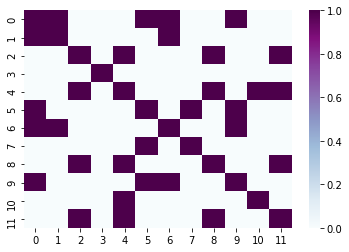

In [200]:
sns.heatmap(sim_array <= np.percentile(list(req.values()), np.linspace(0, 100, 11))[2], cmap = "BuPu")

In [201]:
from sklearn.cluster import DBSCAN

In [202]:
clf = DBSCAN(metric="precomputed", min_samples = 2, leaf_size = 2, eps = 4)
clf.fit(sim_array)

DBSCAN(algorithm='auto', eps=4, leaf_size=2, metric='precomputed',
       metric_params=None, min_samples=2, n_jobs=None, p=None)

In [203]:
clf.labels_

array([-1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1])

In [204]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

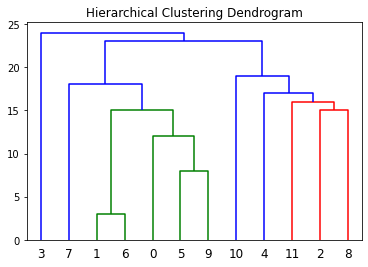

In [205]:
model = AgglomerativeClustering(n_clusters=None,distance_threshold=0, affinity='precomputed', linkage='single')

model = model.fit(sim_array)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=12)

In [207]:
cluster_nest_index = [[0, 1, 5, 6, 9], [2, 8, 11]]
cluster_nest_index.extend([[ele]for ele in set(range(12)).difference(set(cluster_nest_index[0] + cluster_nest_index[1]))])

In [208]:
req = []
for idx, inner_list in enumerate(cluster_nest_index):
    for ele in inner_list:
        req.append((ele, idx))
req_dict = dict(req)

In [212]:
req_df = pd.DataFrame(list(zip(*[list(req_dict.keys()), list(req_dict.values())])))
req_df.columns = ["idx", "cate"]
idx_schoolholiday_str_df = pd.merge(idx_schoolholiday_str_df, req_df, on = "idx", how = "inner")

In [213]:
idx_schoolholiday_str_df

,idx,schoolholiday_str,cate
0,0,1011100000000000000000000111110111000000000000...,0
1,1,1011100000000000000000000000000111000000000000...,0
2,2,0000000000010111110111110000000000000000000000...,1
3,3,1111100000000000000111111111110000000000000000...,3
4,4,0000000001110111110000000000000000000000000000...,4
5,5,1011100000000000000000000111110111000000000000...,0
6,6,1011100000000000000000000000000111000000000000...,0
7,7,1011100000000000000000000111110000000000000000...,5
8,8,1011100000010111110111110000000000000000000000...,1
9,9,1011100000000000000000000111110111000000000000...,0


In [219]:
left = (before_ratio.T / before_ratio.apply(np.sum, axis = 1)).T
right = idx_schoolholiday_str_df

cm = sns.light_palette("green", as_cmap=True)
pd.merge(left.reset_index(), right, left_on = "schoolholiday_str_encode", right_on = "idx", how = "inner")[["a", "b", "c", "d", "cate"]].sort_values(by = "cate", ascending = True).style.background_gradient(cmap=cm)

,a,b,c,d,cate
0,0.660839,0.010490,0.076923,0.251748,0
1,0.466667,0.005556,0.077778,0.450000,0
5,0.493333,0.000000,0.253333,0.253333,0
6,0.452055,0.027397,0.178082,0.342466,0
9,0.555556,0.000000,0.194444,0.250000,0
2,0.643478,0.000000,0.104348,0.252174,1
8,0.300000,0.025000,0.075000,0.600000,1
11,0.545455,0.045455,0.227273,0.181818,1
10,0.607143,0.035714,0.285714,0.071429,2
3,0.357143,0.026786,0.107143,0.508929,3


In [220]:
left = (before_ratio / before_ratio.apply(np.sum, axis = 0))
right = idx_schoolholiday_str_df

cm = sns.light_palette("green", as_cmap=True)
pd.merge(left.reset_index(), right, left_on = "schoolholiday_str_encode", right_on = "idx", how = "inner")[["a", "b", "c", "d", "cate"]].sort_values(by = "cate", ascending = True).style.background_gradient(cmap=cm)

,a,b,c,d,cate
0,0.313953,0.176471,0.148649,0.206897,0
1,0.139535,0.058824,0.094595,0.232759,0
5,0.061462,0.000000,0.128378,0.054598,0
6,0.054817,0.117647,0.087838,0.071839,0
9,0.033223,0.000000,0.047297,0.025862,0
2,0.122924,0.000000,0.081081,0.083333,1
8,0.019934,0.058824,0.020270,0.068966,1
11,0.019934,0.058824,0.033784,0.011494,1
10,0.028239,0.058824,0.054054,0.005747,2
3,0.066445,0.176471,0.081081,0.163793,3


In [221]:
idx_schoolholiday_str_df

,idx,schoolholiday_str,cate
0,0,1011100000000000000000000111110111000000000000...,0
1,1,1011100000000000000000000000000111000000000000...,0
2,2,0000000000010111110111110000000000000000000000...,1
3,3,1111100000000000000111111111110000000000000000...,3
4,4,0000000001110111110000000000000000000000000000...,4
5,5,1011100000000000000000000111110111000000000000...,0
6,6,1011100000000000000000000000000111000000000000...,0
7,7,1011100000000000000000000111110000000000000000...,5
8,8,1011100000010111110111110000000000000000000000...,1
9,9,1011100000000000000000000111110111000000000000...,0


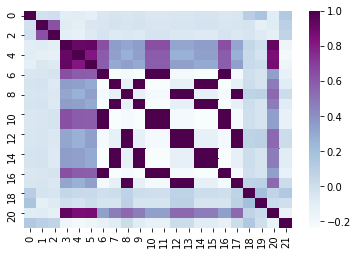

In [222]:
sns.heatmap(rho, cmap = "BuPu")

In [224]:
train_store_expand_date.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2015-07-30,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,2015-07-29,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2015-07-28,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,2015-07-27,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [226]:
store_cp_info_expand_PromoInterval.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
schoolholiday_str             object
PromoInterval_Apr              int64
PromoInterval_Aug              int64
PromoInterval_Dec              int64
PromoInterval_Feb              int64
PromoInterval_Jan              int64
PromoInterval_Jul              int64
PromoInterval_Jun              int64
PromoInterval_Mar              int64
PromoInterval_May              int64
PromoInterval_Nov              int64
PromoInterval_Oct              int64
PromoInterval_Sept             int64
StoreType_encode               int64
Assortment_encode              int64
PromoInterval_encode           int64
schoolholiday_str_encode       int64
d

In [230]:
store_cp_info_expand_PromoInterval.columns.tolist()[store_cp_info_expand_PromoInterval.columns.tolist().index("PromoInterval_Apr"):]

['PromoInterval_Apr',
 'PromoInterval_Aug',
 'PromoInterval_Dec',
 'PromoInterval_Feb',
 'PromoInterval_Jan',
 'PromoInterval_Jul',
 'PromoInterval_Jun',
 'PromoInterval_Mar',
 'PromoInterval_May',
 'PromoInterval_Nov',
 'PromoInterval_Oct',
 'PromoInterval_Sept',
 'StoreType_encode',
 'Assortment_encode',
 'PromoInterval_encode',
 'schoolholiday_str_encode']

In [240]:
def transform_columns(left, right):
    assert "Store" in left.columns.tolist() and "Store" in right.columns.tolist()
    right_encoded_colnames = list(filter(lambda colname: colname.endswith("_encode") ,right.columns.tolist()))
    right_encoded_colnames.remove("schoolholiday_str_encode")
    print("add num : {}".format(len(right_encoded_colnames)))
    left_replace_colnames = list(map(lambda colname: colname.replace("_encode", ""), right_encoded_colnames))          
    assert len(left_replace_colnames) == len(set(left_replace_colnames).intersection(set(left.columns.tolist())))
    left_before_merge = left.copy()
    for col in left_replace_colnames:
        del left_before_merge[col]
    right_before_merge = right.copy()
    merged = pd.merge(left = left_before_merge, right = right_before_merge, on = "Store", how = "inner")
    assert left.shape[0] == merged.shape[0]
    return merged
    

In [252]:
right_cols = store_cp_info_expand_PromoInterval.columns.tolist()[store_cp_info_expand_PromoInterval.columns.tolist().index("PromoInterval_Apr"):]
right_cols = ["Store"] + right_cols
train_store_encoded = transform_columns(left = train_store_expand_date, right = store_cp_info_expand_PromoInterval[right_cols])

add num : 3


In [288]:
obj_cols = train_store_encoded.dtypes.map(str)[train_store_encoded.dtypes.map(str) == "object"].index.tolist()
for col in obj_cols:
    train_store_encoded["{}_encode".format(col)] = simple_cate_encode(train_store_encoded[col])
    del train_store_encoded[col]

In [289]:
train_store_encoded.dtypes

Date                         datetime64[ns]
Store                                 int64
DayOfWeek                             int64
Sales                                 int64
Customers                             int64
Promo                                 int64
SchoolHoliday                         int64
Year                                  int64
Month                                 int64
Day                                   int64
WeekOfYear                            int64
SalesPerCustomer                    float64
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval_Apr                     int64
PromoInterval_Aug                     int64
PromoInterval_Dec                     int64
PromoInterval_Feb                     int64
PromoInterval_Jan               

In [291]:
if "Open" in train_store_encoded.columns.tolist():
    del train_store_encoded["Open"]

In [292]:
int_cols = train_store_encoded.dtypes.map(str)[train_store_encoded.dtypes.map(str) == "int64"].index.tolist()

In [293]:
int_cols_stats = train_store_encoded[int_cols].apply(lambda s: len(s.value_counts()), axis = 0)

In [294]:
bool_cols = int_cols_stats[int_cols_stats == 2]
bool_stats = int_cols_stats.loc[bool_cols.index]
others = list(set(int_cols_stats.index.tolist()).difference(set(bool_cols.index.tolist())))
other_stats = int_cols_stats.loc[others]
encode_cols = list(filter(lambda x: x.endswith("_encode"), other_stats.index.tolist()))
encode_stats = int_cols_stats.loc[encode_cols]
others = list(set(others).difference(set(encode_stats.index.tolist())))
other_stats = int_cols_stats.loc[others]

In [295]:
other_stats

Sales         21733
Year              3
Store          1115
WeekOfYear       52
DayOfWeek         7
Customers      4083
Month            12
Day              31
dtype: int64

In [296]:
int_cols_stats_list = [bool_stats, encode_stats, other_stats]

In [297]:
int_cols_stats_list[0]

Promo                 2
SchoolHoliday         2
Promo2                2
PromoInterval_Apr     2
PromoInterval_Aug     2
PromoInterval_Dec     2
PromoInterval_Feb     2
PromoInterval_Jan     2
PromoInterval_Jul     2
PromoInterval_Jun     2
PromoInterval_Mar     2
PromoInterval_May     2
PromoInterval_Nov     2
PromoInterval_Oct     2
PromoInterval_Sept    2
dtype: int64

In [298]:
int_cols_stats_list[1]

StateHoliday_encode          4
StoreType_encode             4
Assortment_encode            3
PromoInterval_encode         4
schoolholiday_str_encode    12
dtype: int64

In [299]:
int_cols_stats_list[2]

Sales         21733
Year              3
Store          1115
WeekOfYear       52
DayOfWeek         7
Customers      4083
Month            12
Day              31
dtype: int64

In [303]:
float_cols = train_store_encoded.dtypes.map(str)[train_store_encoded.dtypes.map(str) == "float64"].index.tolist()

In [307]:
float_stats = train_store_encoded[float_cols].apply(lambda x: len(x.value_counts()), axis = 0)

In [308]:
ds_stats = train_store_encoded[train_store_encoded.dtypes.map(str)[train_store_encoded.dtypes.map(str) == "datetime64[ns]"].index.tolist()].apply(lambda x: len(x.value_counts()), axis = 0)

In [311]:
all_cols_stats_list = int_cols_stats_list + [float_stats, ds_stats]

In [315]:
from functools import reduce
assert reduce(lambda a, b: a + b ,map(len ,all_cols_stats_list)) == train_store_encoded.shape[1]

In [322]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_part = enc.fit_transform(train_store_encoded[encode_stats.index.tolist()])

In [331]:
pd.DataFrame(enc_part.toarray()).apply(lambda x: len(x.value_counts()), axis = 0)

0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
dtype: int64

In [335]:
req = []
for col_stats_idx in set(range(len(all_cols_stats_list))).difference(set([1])):
    req.append(train_store_encoded[all_cols_stats_list[col_stats_idx].index.tolist()])
req.append(enc_part)

In [355]:
list(map(lambda x: x.shape, req))

[(844338, 15), (844338, 8), (844338, 6), (844338, 1), (844338, 27)]

In [341]:
req[-2].drop_duplicates().shape

(942, 1)

In [364]:
train_store_encoded_onehot = pd.concat(map(lambda x: x if type(x) == type(pd.DataFrame()) else pd.DataFrame(x.toarray()) ,req), axis = 1)

In [367]:
train_store_encoded_onehot.columns, train_store_encoded_onehot.shape

(Index([                    'Promo',             'SchoolHoliday',
                           'Promo2',         'PromoInterval_Apr',
                'PromoInterval_Aug',         'PromoInterval_Dec',
                'PromoInterval_Feb',         'PromoInterval_Jan',
                'PromoInterval_Jul',         'PromoInterval_Jun',
                'PromoInterval_Mar',         'PromoInterval_May',
                'PromoInterval_Nov',         'PromoInterval_Oct',
               'PromoInterval_Sept',                     'Sales',
                             'Year',                     'Store',
                       'WeekOfYear',                 'DayOfWeek',
                        'Customers',                     'Month',
                              'Day',          'SalesPerCustomer',
              'CompetitionDistance', 'CompetitionOpenSinceMonth',
         'CompetitionOpenSinceYear',           'Promo2SinceWeek',
                  'Promo2SinceYear',                      'Date',
          

In [370]:
train_store_encoded.to_csv("train_store_encoded.csv", index = False)

In [371]:
train_store_expand_date.to_csv("train_store_expand_date.csv", index = False)

In [372]:
train_store_encoded_onehot.to_csv("train_store_encoded_onehot.csv", index = False)